In [1]:
# Import necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import pulp

# Constants from the paper
eta_ch = 0.9  # Charging efficiency
eta_dis = 0.9  # Discharging efficiency
P_max = 10  # Maximum power from PV system
N_BEVs = 4  # Number of BEVs
Delta_t = 1  # Time period duration in hours
amount = 36

# Instantiate parameters
rng = np.random.default_rng(seed=42)  # Random number generator for price vector
price = rng.random(amount) * 10  # Vector containing 24 prices

# Create the problem variable
problem = pulp.LpProblem("EV_Charging_Optimization", pulp.LpMinimize)

# Variables for the MILP problem
P_G2Vi_t = [pulp.LpVariable(f"P_G2Vi_t{i}", 0, P_max) for i in range(amount)]
P_PV2G_t = [pulp.LpVariable(f"P_PV2G_t{i}", 0, P_max) for i in range(amount)]

# Objective function
problem += pulp.lpSum(price[t] * P_G2Vi_t[t] for t in range(amount)), "Total Charging Cost"

# Constraints from the paper
# Ensure the total energy charged is within a specific range
problem += pulp.lpSum(P_G2Vi_t[t] * eta_ch for t in range(amount)) >= 0.9 * DeltaE, "constraint1_lower"
problem += pulp.lpSum(P_G2Vi_t[t] * eta_ch for t in range(amount)) <= 1.1 * DeltaE, "constraint1_upper"

# Additional constraints based on the paper's EMS design
# Add constraints related to PV power production, grid interaction, and BEV parameters

# Solve the problem
problem.solve()

# Extract decision variables
decision_var = [v.varValue for v in P_G2Vi_t]

# Save decision variables
np.save('decision_var.npy', decision_var)
print("Decision variables saved to 'decision_var.npy'")

# Calculate state of charge (SOC) assuming initial SOC of 20%
initial_soc = 20
soc_list = [initial_soc]
for t in range(amount):
    soc_list.append(soc_list[-1] + decision_var[t] * eta_ch * 100 / max_cap)
soc_array = np.array(soc_list[1:])

# Plotting
x = np.arange(amount)
y1 = [var / P_max for var in decision_var]  # Total charging action normalized by P_max
y2 = soc_array / 100  # SOC normalized to 1
y3 = price

fig, ax1 = plt.subplots()
ax1.plot(x, y1, color='r', label='action')
ax1.plot(x, y2, color='green', label='SOC')
ax1.set_title('Charging action vs time')
ax1.set_xticks(x)
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Action/SOC (normalized)', color='black')

ax2 = ax1.twinx()
ax2.plot(x, y3, color='b', label='price')
ax2.set_ylabel('price (EUR/kWh)', color='b')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

print(f"Charging schedule = {decision_var}")
print(f"Total bought energy in kWh = {sum(decision_var)}")


NameError: name 'DeltaE' is not defined

Decision variables saved to 'decision_var.npy'


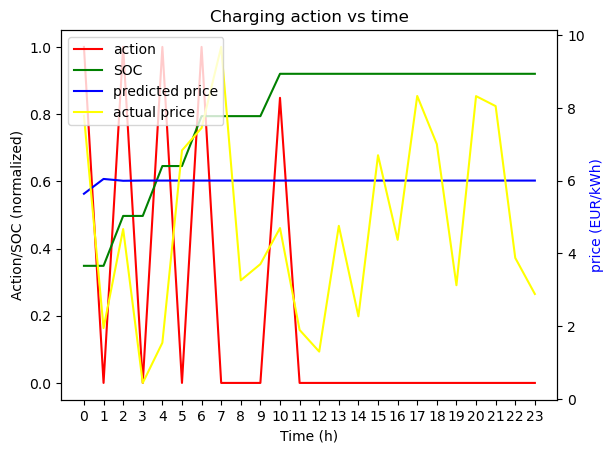

Charging schedule = [6.6, 0.0, 6.6, 0.0, 6.6, 0.0, 6.6, 0.0, 0.0, 0.0, 5.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Total bought energy in kWh = 32.0


In [7]:
# Import necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import pulp
from statsmodels.tsa.arima.model import ARIMA

# Instantiate parameters
rng = np.random.default_rng(seed=42)  # Random number generator for price vector
price = rng.random(48) * 10  # Vector containing 48 prices

# Use the first half of the price vector to predict the next prices
train_prices = price[:24]
model = ARIMA(train_prices, order=(1, 1, 1))
model_fit = model.fit()
predicted_prices = model_fit.predict(start=24, end=47)

# Constants
eta_c = 0.9
max_cap = 40
DeltaE = max_cap * (100 - 20) / 100
P_max = 6.6  # Maximum charging power

# Create the problem variable
problem = pulp.LpProblem("EV_Charging_Optimization", pulp.LpMinimize)

# Variables for the MILP problem
P_G2Vi_t = [pulp.LpVariable(f"P_G2Vi_t{i}", 0, P_max) for i in range(24)]

# Objective function
problem += pulp.lpSum(predicted_prices[t-24]*P_G2Vi_t[t] for t in range(24)), "Total Charging Cost"

# Constraints
problem += pulp.lpSum(P_G2Vi_t[t]*eta_c for t in range(24)) >= 0.9*DeltaE, "constraint1_lower"
problem += pulp.lpSum(P_G2Vi_t[t]*eta_c for t in range(24)) <= 1.1*DeltaE, "constraint1_upper"

# Solve the problem
problem.solve()

# Extract decision variables and save them
decision_var = [v.varValue for v in P_G2Vi_t]
np.save('decision_var.npy', decision_var)
print("Decision variables saved to 'decision_var.npy'")

# Calculate state of charge (SOC) assuming initial SOC of 20%
initial_soc = 20
soc_list = [initial_soc]
for t in range(24):
    soc_list.append(soc_list[-1] + decision_var[t] * eta_c * 100 / max_cap)
soc_array = np.array(soc_list[1:])

# Plotting
x = np.arange(24)
y1 = [var / P_max for var in decision_var]  # Total charging action normalized by P_max
y2 = soc_array / 100  # SOC normalized to 1
y3 = predicted_prices  # Predicted prices
y4 = price[24:48]  # Actual prices

fig, ax1 = plt.subplots()
ax1.plot(x, y1, color='r', label='action')
ax1.plot(x, y2, color='green', label='SOC')
ax1.set_title('Charging action vs time')
ax1.set_xticks(x)
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Action/SOC (normalized)', color='black')

ax2 = ax1.twinx()
ax2.plot(x, y3, color='b', label='predicted price')
ax2.plot(x, y4, color='yellow', label='actual price')
ax2.set_ylabel('price (EUR/kWh)', color='b')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

print(f"Charging schedule = {decision_var}")
print(f"Total bought energy in kWh = {sum(decision_var)}")


In [9]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary

# Load the data
data = pd.read_excel('energy_prices.xlsx')
print(data.head())

  Beschikbaar gesteld door jeroen.nl            Unnamed: 1
0                          datumtijd  Inkoop prijs per kWh
1                2013-01-01 01:00:00                0.0326
2                2013-01-01 02:00:00                0.0316
3                2013-01-01 03:00:00                0.0306
4                2013-01-01 04:00:00                0.0293


Index(['datumtijd', 'Inkoop prijs per kWh'], dtype='object')


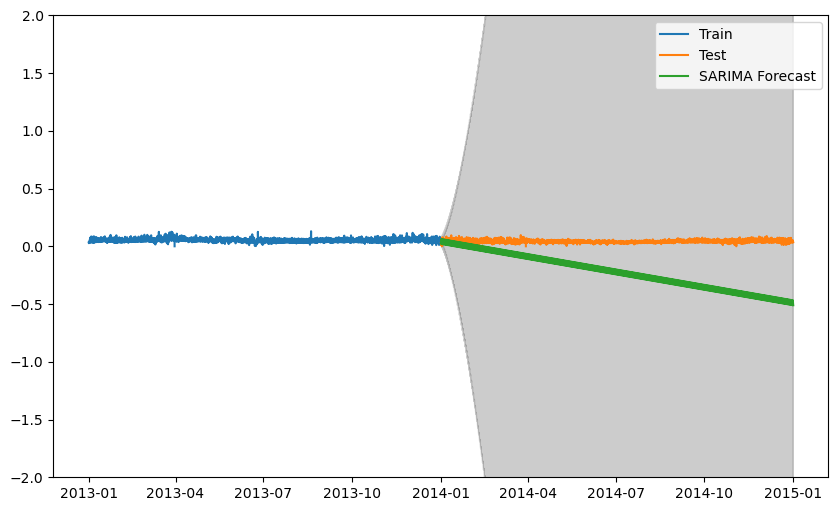

ValueError: x and y must have same first dimension, but have shapes (8761,) and (10,)

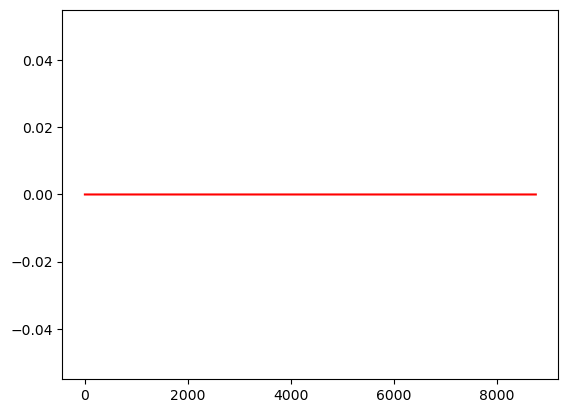

In [4]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary

data = pd.read_excel('energy_prices.xlsx', skiprows=1)

# Check the column names
print(data.columns)

# Rename columns if necessary (adjust to match your file's column names)
data.columns = ['datumtijd', 'Inkoop prijs per kWh']

# Ensure the datetime column is in the correct format
data['datumtijd'] = pd.to_datetime(data['datumtijd'])
data.set_index('datumtijd', inplace=True)

# Resample data to hourly average if necessary
data = data.resample('H').mean()

start_date_train = data.index.min()
end_date_train = start_date_train + pd.DateOffset(years=1)

start_date_test = end_date_train
end_date_test = start_date_test + pd.DateOffset(years=1)

train_data = data.loc[start_date_train:end_date_train]
test_data = data.loc[start_date_test:end_date_test]

# Fit SARIMA model (parameters can be tuned)
sarima_model = sm.tsa.statespace.SARIMAX(train_data['Inkoop prijs per kWh'],
                                         order=(1, 1, 3),
                                         seasonal_order=(0, 1, 1, 48)).fit()

# Forecast
sarima_forecast = sarima_model.get_forecast(steps=len(test_data))
forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data['Inkoop prijs per kWh'], label='Train')
plt.plot(test_data['Inkoop prijs per kWh'], label='Test')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='k', alpha=.2)
plt.ylim(-2, 2)  # Set y-axis limits
plt.legend()
plt.show()

# Define the model
model = LpProblem("EV_Charging", LpMinimize)

# Parameters
T = len(test_data)
C = 10  # Number of cars
Pmax = 7  # Maximum charging power per car (kW)
Emax = 50  # Maximum battery capacity per car (kWh)
eta_ch = 0.9  # Charging efficiency
prices = sarima_forecast.predicted_mean.values

# Variables
P = LpVariable.dicts("P", ((c, t) for c in range(C) for t in range(T)), lowBound=0, upBound=Pmax, cat='Continuous')
E = LpVariable.dicts("E", ((c, t) for c in range(C) for t in range(T)), lowBound=0, upBound=Emax, cat='Continuous')
u = LpVariable.dicts("u", ((c, t) for c in range(C) for t in range(T)), cat='Binary')

# Objective: Minimize total cost
model += lpSum(prices[t] * P[c, t] for c in range(C) for t in range(T))

# Constraints
for c in range(C):
    for t in range(T):
        if t == 0:
            model += E[c, t] == 0  # Initial SoC
        else:
            model += E[c, t] == E[c, t-1] + eta_ch * P[c, t]
        model += P[c, t] <= Pmax * u[c, t]  # Power limits
        model += E[c, t] <= Emax  # SoC limits

# Solve the problem
model.solve()

# Extract results
charging_power = pd.DataFrame([[P[c, t].varValue for t in range(T)] for c in range(C)])
soc = pd.DataFrame([[E[c, t].varValue for t in range(T)] for c in range(C)])

# Plot the State of Charge (SoC) for each car
plt.figure(figsize=(14, 8))
for c in range(C):
    plt.plot(soc.iloc[c, :], label=f'Car {c+1}')
plt.xlabel('Time (hours)')
plt.ylabel('State of Charge (kWh)')
plt.legend()
plt.show()

# Plot the charging power against electricity prices
plt.figure(figsize=(14, 8))
plt.plot(prices, label='Electricity Prices')
plt.plot(charging_power.sum(axis=0), label='Total Charging Power')
plt.xlabel('Time (hours)')
plt.ylabel('Power (kW) / Price (€)')
plt.ylim(0, 2)  # Set y-axis limits
plt.legend()
plt.show()
